In [1]:
import requests
import folium

def extract_osm_geodata(query):
    """
    Extracts geodata from OpenStreetMap using the Overpass API.
    Parameters:
    query (str): The Overpass API query string to execute.
    Returns:
    dict: GeoJSON data retrieved by the query.
    """
    # Define the Overpass API URL
    overpass_url = "https://lz4.overpass-api.de/api/interpreter"
    
    # Define the parameters for the GET request
    params = {'data': query}
    
    # Send a GET request to the Overpass API with the query
    response = requests.get(overpass_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()

In [2]:
# Query to extract subway stations in Madrid
query = """
[out:json];
area[name="Madrid"]->.searchArea;
relation["route"~"subway"](area.searchArea);
out meta;
>;
out body;
"""
subway_madrid_data = extract_osm_geodata(query)

In [3]:
def extract_route_elements(osm_data):
    """
    Extracts route elements from the OpenStreetMap data response.
    Parameters:
    osm_data (dict): The JSON response data from the Overpass API.
    Returns:
    list: A list of route elements containing 'tags' with 'route' information.
    """
    route_elements = [element for element in osm_data['elements'] if 'tags' in element and 'route' in element['tags']]
    return route_elements

# Call the function to extract route elements from the OpenStreetMap data for London's subway
route_elements =  extract_route_elements(subway_madrid_data)

# Visualize the route of the list
route_elements[0]

{'type': 'relation',
 'id': 56044,
 'timestamp': '2021-09-16T12:08:55Z',
 'version': 25,
 'changeset': 111288295,
 'user': 'Cuenqui',
 'uid': 3649461,
 'members': [{'type': 'node', 'ref': 258556530, 'role': 'stop'},
  {'type': 'way', 'ref': 695700309, 'role': 'platform'},
  {'type': 'node', 'ref': 299642717, 'role': 'stop'},
  {'type': 'node', 'ref': 299642733, 'role': 'stop'},
  {'type': 'node', 'ref': 427885573, 'role': 'stop'},
  {'type': 'node', 'ref': 23646367, 'role': 'stop'},
  {'type': 'node', 'ref': 427885568, 'role': 'stop'},
  {'type': 'node', 'ref': 344477421, 'role': 'stop'},
  {'type': 'way', 'ref': 695703647, 'role': ''},
  {'type': 'way', 'ref': 549231891, 'role': ''},
  {'type': 'way', 'ref': 549232817, 'role': ''}],
 'tags': {'colour': '#006400',
  'from': 'Plaza Elíptica',
  'name': 'Línea 11: Plaza Elíptica-La Fortuna',
  'network': 'Metro de Madrid',
  'network:wikidata': 'Q191987',
  'network:wikipedia': 'es:Metro de Madrid',
  'opening_hours': 'Mo-Su 06:00-01:30'

In [4]:
def extract_node_elements(osm_data):
    """
    Extracts node elements from the OpenStreetMap data response.
    Parameters:
    osm_data (dict): The JSON response data from the Overpass API.
    Returns:
    dict: A dictionary where the keys are node IDs and the values are the corresponding node elements.
    """
    node_elements = {element['id']: element for element in osm_data['elements'] if element['type'] == 'node'}
    return node_elements

# Call the function to extract node elements from the OpenStreetMap data for Hamburg's subway
node_elements = extract_node_elements(subway_madrid_data)

# Visualize the node_elements list
node_elements

{20962897: {'type': 'node',
  'id': 20962897,
  'lat': 40.4224813,
  'lon': -3.6121729,
  'tags': {'covered': 'yes',
   'fare_area': 'A',
   'name': 'Avenida de Guadalajara',
   'operator': 'Metro de Madrid',
   'public_transport': 'stop_position',
   'railway': 'stop',
   'subway': 'yes',
   'wheelchair': 'yes'}},
 21722641: {'type': 'node',
  'id': 21722641,
  'lat': 40.3844291,
  'lon': -3.7510838,
  'tags': {'colour': '#51D532',
   'covered': 'yes',
   'fare_area': 'A',
   'name': 'Eugenia de Montijo',
   'operator': 'Metro de Madrid',
   'public_transport': 'stop_position',
   'railway': 'stop',
   'subway': 'yes',
   'wheelchair': 'yes'}},
 21722642: {'type': 'node',
  'id': 21722642,
  'lat': 40.3838514,
  'lon': -3.7522303},
 21722643: {'type': 'node',
  'id': 21722643,
  'lat': 40.3836495,
  'lon': -3.7529137},
 21722644: {'type': 'node',
  'id': 21722644,
  'lat': 40.3835571,
  'lon': -3.7537554},
 21722646: {'type': 'node',
  'id': 21722646,
  'lat': 40.3839897,
  'lon': -3.

In [5]:
import networkx as nx

def create_route_graph(route_elements, node_elements):
    """
    Creates a graph of routes with stop nodes and edges between consecutive stops.
    Parameters:
    route_elements (list): A list of route elements containing 'members' and 'tags'.
    node_elements (dict): A dictionary of node elements with their IDs as keys.
    Returns:
    nx.Graph: A NetworkX graph object representing the routes and stop nodes.
    """
    # Create a graph object
    G = nx.Graph()

    for route in route_elements:
        stop_nodes = [member for member in route['members'] if 'stop' in member['role']]
        
        # Add nodes to the graph
        for node in stop_nodes:
            ref = node['ref']
            if ref in node_elements:
                node_data = node_elements[ref]
                name = node_data['tags'].get('name', str(ref))
                colour = route['tags'].get('colour', '#808080')  # Default gray color if no color is defined
                
                G.add_node(ref, pos=(node_data['lon'], node_data['lat']), name=name, colour=colour)
        
        # Add edges between consecutive stop nodes
        for i in range(len(stop_nodes) - 1):
            G.add_edge(stop_nodes[i]['ref'], stop_nodes[i + 1]['ref'])
    
    return G

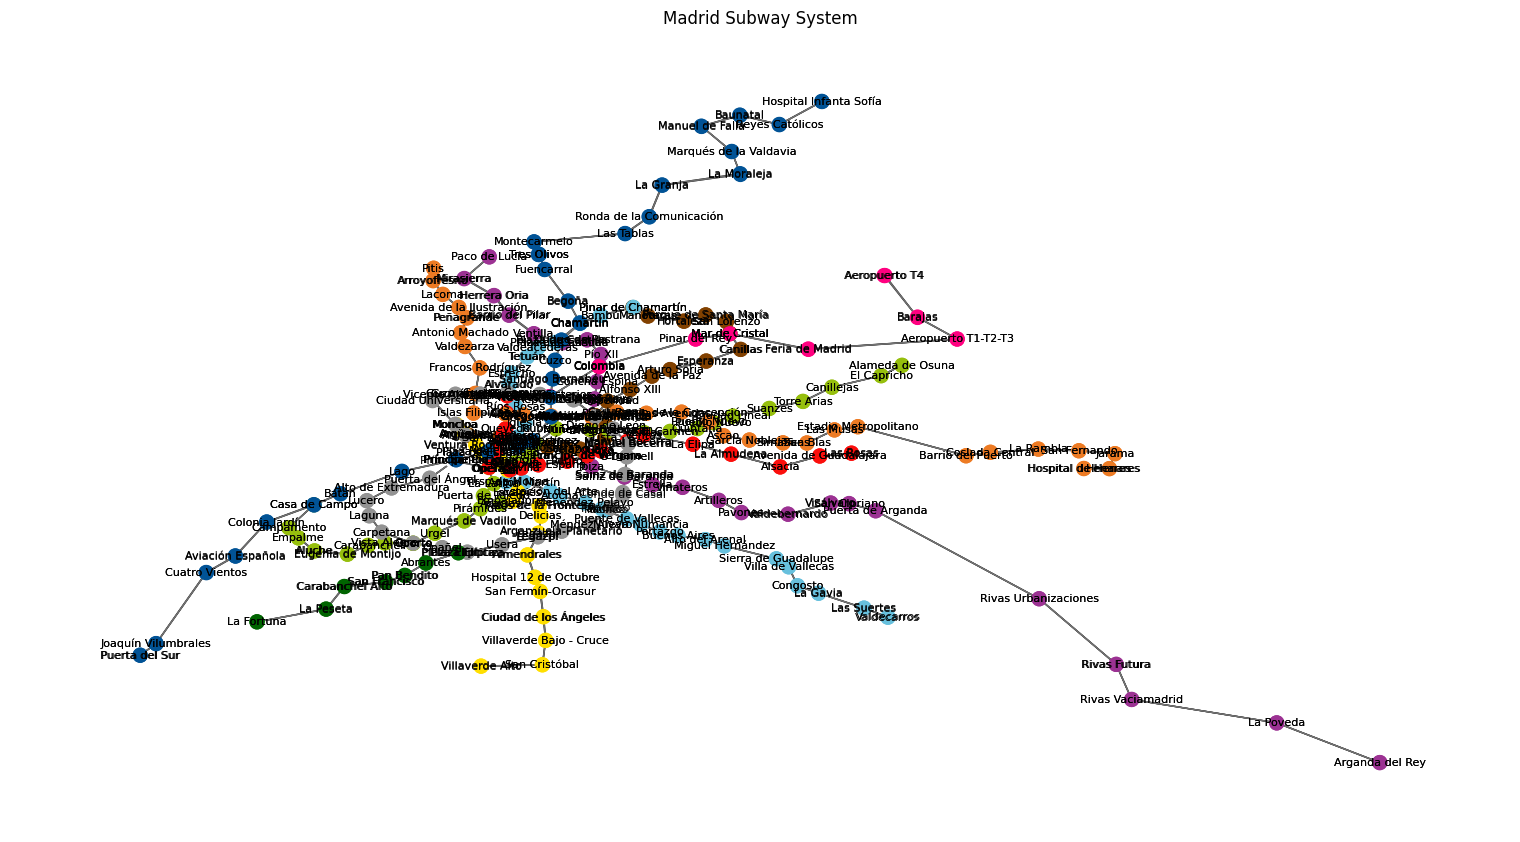

In [6]:
import matplotlib.pyplot as plt

def visualize_graph(G, title):
    """
    Visualizes the graph with nodes and edges.
    Parameters:
    G (nx.Graph): A NetworkX graph object representing the routes and stop nodes.
    Returns:
    None: Displays a plot of the graph.
    """
    # Set the plot size
    plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

    # Draw the graph with nodes and edges
    pos = nx.get_node_attributes(G, 'pos')
    node_labels = nx.get_node_attributes(G, 'name')
    node_colours = list(nx.get_node_attributes(G, 'colour').values())
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=100, node_color=node_colours, font_size=8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.show()

# Create the graph for the Hamburg subway system
subway_madrid_G = create_route_graph(route_elements, node_elements)

# Visualize the graph with a title
visualize_graph(subway_madrid_G, 'Madrid Subway System')

In [7]:
import folium

def visualize_graph_on_folium(G, title, map_center=(40.4168, -3.7038), zoom_start=12):
    """
    Visualizes a NetworkX graph on an interactive Folium map.
    Parameters:
    G (nx.Graph): A NetworkX graph object representing the subway network.
    title (str): Title for the map.
    map_center (tuple): Latitude and longitude for centering the map.
    zoom_start (int): Initial zoom level for the map.
    Returns:
    folium.Map: A Folium map object with the graph plotted.
    """
    # Create a Folium map centered on the specified coordinates
    subway_map = folium.Map(location=map_center, zoom_start=zoom_start)
    
    # Get positions and attributes from the graph
    pos = nx.get_node_attributes(G, 'pos')  # Node positions
    node_colours = nx.get_node_attributes(G, 'colour')  # Node colors
    node_names = nx.get_node_attributes(G, 'name')  # Node names
    
    # Add nodes as markers
    for node, coords in pos.items():
        name = node_names.get(node, "Unnamed Station")
        colour = node_colours.get(node, "#000000")  # Default black if no color specified
        folium.CircleMarker(
            location=(coords[1], coords[0]),  # Folium uses (lat, lon)
            radius=5,
            color=colour,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(name, max_width=300)
        ).add_to(subway_map)
    
    # Add edges as polylines
    for edge in G.edges():
        coord1 = pos[edge[0]]
        coord2 = pos[edge[1]]
        colour = node_colours.get(edge[0], "gray")  # Use the color of the first node in the edge
        folium.PolyLine(
            locations=[(coord1[1], coord1[0]), (coord2[1], coord2[0])],  # Folium uses (lat, lon)
            color=colour,
            weight=2,
            opacity=0.6
        ).add_to(subway_map)
    
    # Add a title to the map (via a custom HTML overlay)
    title_html = f'''
         <h3 align="center" style="font-size:16px"><b>{title}</b></h3>
         '''
    subway_map.get_root().html.add_child(folium.Element(title_html))
    
    return subway_map

# Create the Folium map
madrid_subway_map = visualize_graph_on_folium(subway_madrid_G, "Madrid Subway Network")

# Save the map to an HTML file
madrid_subway_map.save("madrid_subway_network.html")
print("Map saved as 'madrid_subway_network.html'!")

madrid_subway_map

Map saved as 'madrid_subway_network.html'!
